In [112]:
import numpy as np
#import os
import PIL
import PIL.Image
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from tensorflow import keras
import tensorflow_addons as tfa
import time
from keras import regularizers



In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [3]:
import pathlib
#https://cdn-144.anonfiles.com/J8c8S3s0p4/935d48c2-1606216539/data.tar.gz
data = r"C:\Users\tobia\Samlet CNN\data"
data_dir = pathlib.Path(data)
type(data_dir)


pathlib.WindowsPath

In [4]:
image_count = len(list(data_dir.glob('*/*/*.png')))
print(image_count)

35886


In [5]:
#Train
train_ds = tf.data.Dataset.list_files(str(data_dir/'train/*/*'), shuffle=False)
train_ds = train_ds.shuffle(image_count, reshuffle_each_iteration=False)
#Val
val_ds = tf.data.Dataset.list_files(str(data_dir/'val/*/*'), shuffle=False)
val_ds = val_ds.shuffle(image_count, reshuffle_each_iteration=False)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())


28709
3589


In [6]:
for f in train_ds.take(5):
    print(f.numpy())

b'C:\\Users\\tobia\\Samlet CNN\\data\\train\\4\\12762.png'
b'C:\\Users\\tobia\\Samlet CNN\\data\\train\\3\\3351.png'
b'C:\\Users\\tobia\\Samlet CNN\\data\\train\\0\\14445.png'
b'C:\\Users\\tobia\\Samlet CNN\\data\\train\\4\\5516.png'
b'C:\\Users\\tobia\\Samlet CNN\\data\\train\\6\\10466.png'


In [7]:
class_names = np.array(sorted([item.name for item in data_dir.glob('train/*') if item.name != "LICENSE.txt"]))
print(class_names)

['0' '1' '2' '3' '4' '5' '6']


In [90]:
batch_size = 64
img_height = 48
img_width = 48

In [9]:
def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original,cmap='gray')

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented,cmap='gray')

In [10]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [11]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=1)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [12]:
def process_path(file_path):
    label = get_label(file_path)
  # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [13]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

Image shape:  (48, 48, 1)
Label:  4


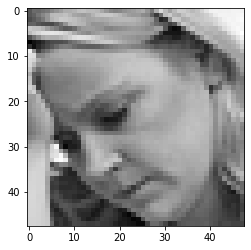

In [14]:
for image, label in train_ds.take(1):
    plt.imshow(image.numpy().astype("uint8"),cmap='gray')
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

In [15]:
def resize_and_rescale(image, label):
    #image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [img_height, img_width])
    #image = (image/ 255.0)
    #image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
    return image, label


In [16]:
def augment(image,label):
    random_number = random.uniform(0.1,0.8)
    random_number_flip = random.uniform(0,2)
    image, label = resize_and_rescale(image, label)
    # Add 6 pixels of padding
    image = tf.image.resize_with_crop_or_pad(image, img_height + 6, img_width + 6) 
    # Random crop back to the original size
    image = tf.image.random_crop(image, size=[img_height, img_width, 1])
    
    #shear
    random_number_shear = random.uniform(-0.3,0.3)
    shear = random_number_shear
    shear_rotate = shear * -20
    image = tfa.image.transform(image, [1.0, shear, shear_rotate, 0.0, 1.0, 0.0, 0.0, 0.0])

    #distortion
    random_number_distortion = random.uniform(0,5)
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=random_number_distortion, dtype=tf.float32)
    image = tf.add(image, noise)
    
    #random erase
    #image = tfa.image.random_cutout(image, (10,10), constant_values = 0)
        
    if random_number_flip > 1:
        image = tf.image.flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness    
    return image, label

Image shape:  (48, 48, 1)
Label:  4
<ParallelMapDataset shapes: ((48, 48, 1), ()), types: (tf.float32, tf.int64)>
<PrefetchDataset shapes: ((None, 48, 48, 1), (None,)), types: (tf.float32, tf.int64)>


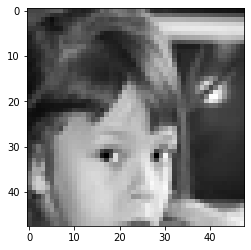

In [17]:
for image, label in train_ds.take(1):
    plt.imshow(image.numpy().astype("uint8"),cmap='gray')
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    print(train_ds)
    
train_ds = (
    train_ds
    .shuffle(1000)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)    
orgDataset = train_ds

#.map(augment, num_parallel_calls=AUTOTUNE)
print(train_ds)

val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

image_batch, label_batch = next(iter(train_ds))
plt.imshow(image_batch[1].numpy().astype("uint8"),cmap='gray')


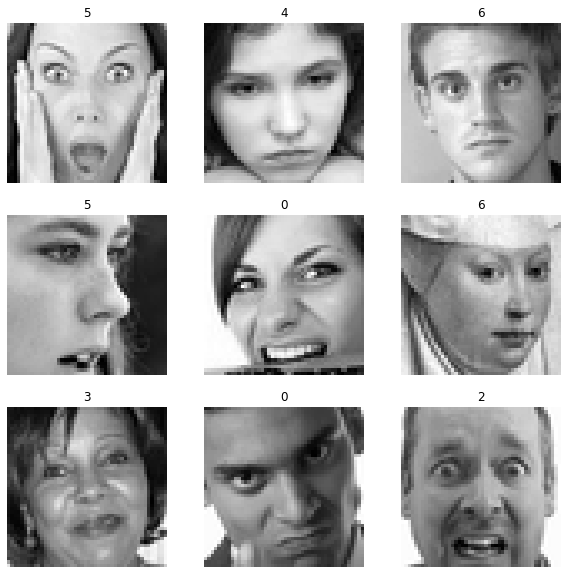

In [18]:
image_batch, label_batch = next(iter(train_ds))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"),cmap='gray')
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")


In [19]:
image = image_batch[1].numpy().astype("uint8")
#visualize(image, flipped)
type(image)

numpy.ndarray

In [20]:
class CustomCallback(keras.callbacks.Callback):
   
    def on_epoch_end(self, epoch, logs=None):      
        image_batch, label_batch = next(iter(train_ds))
        plt.figure(figsize=(10, 10))
        for i in range(1):
            ax = plt.subplot(2, 2, i + 1)
            plt.imshow(image_batch[i].numpy().astype("uint8"),cmap='gray')
            label = label_batch[i]
            plt.title(class_names[label])
            plt.axis("off")

In [21]:
def visualize2(original):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    image = colorImage(original)
    plt.imshow(image)

In [22]:
def flipImage(image):
    flipped = tf.image.flip_left_right(image)
    
def colorImage(image):
    image = tf.image.adjust_brightness(image,0.5)
    return image

In [ ]:
from tensorflow.keras import layers

#normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

num_classes = 7
cnn = tf.keras.models.Sequential([
layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[48, 48, 1]),
layers.MaxPool2D(pool_size=2, strides=2),
layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
layers.MaxPool2D(pool_size=2, strides=2),
layers.Flatten(),
layers.Dense(units=128, activation='relu'),
layers.Dense(units=7,activation='softmax')
])

cnn.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])



In [91]:
from tensorflow.keras import layers
model = tf.keras.models.Sequential([
layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =[48, 48, 1]),
layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
layers.BatchNormalization(),
layers.MaxPool2D(pool_size=2, strides=2),
layers.Dropout(0.25),
    
layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
layers.Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
layers.BatchNormalization(),
layers.MaxPool2D(pool_size=2, strides=2),
layers.Dropout(0.25),

layers.Flatten(),
layers.Dense(1024, activation='relu'),
layers.Dropout(0.5),
layers.Dense(units=7,activation='softmax')
])
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])



In [54]:
from tensorflow.keras import layers

     #Initialising the CNN
model = tf.keras.models.Sequential()   

model.add(layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =[48, 48, 1]))
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
    
model.add(layers.Dense(7, activation='softmax'))
from keras.optimizers import Adam, RMSprop, SGD

    #Compliling the model
model.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
                  loss=tf.losses.SparseCategoricalCrossentropy, 
                  metrics=['accuracy'])
    

In [56]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization_13 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 22, 22, 256)     

Epoch 1/60


ValueError: in user code:

    C:\Users\tobia\anaconda3\envs\gpu_test\lib\site-packages\tensorflow\python\keras\engine\training.py:837 train_function  *
        return step_function(self, iterator)
    C:\Users\tobia\anaconda3\envs\gpu_test\lib\site-packages\tensorflow\python\keras\engine\training.py:827 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\tobia\anaconda3\envs\gpu_test\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1263 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\tobia\anaconda3\envs\gpu_test\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2735 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\tobia\anaconda3\envs\gpu_test\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3424 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\tobia\anaconda3\envs\gpu_test\lib\site-packages\tensorflow\python\keras\engine\training.py:820 run_step  **
        outputs = model.train_step(data)
    C:\Users\tobia\anaconda3\envs\gpu_test\lib\site-packages\tensorflow\python\keras\engine\training.py:787 train_step
        loss = self.compiled_loss(
    C:\Users\tobia\anaconda3\envs\gpu_test\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\tobia\anaconda3\envs\gpu_test\lib\site-packages\tensorflow\python\keras\losses.py:152 __call__
        losses = call_fn(y_true, y_pred)
    C:\Users\tobia\anaconda3\envs\gpu_test\lib\site-packages\tensorflow\python\keras\losses.py:256 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\tobia\anaconda3\envs\gpu_test\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\tobia\anaconda3\envs\gpu_test\lib\site-packages\tensorflow\python\keras\losses.py:1537 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    C:\Users\tobia\anaconda3\envs\gpu_test\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\tobia\anaconda3\envs\gpu_test\lib\site-packages\tensorflow\python\keras\backend.py:4940 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    C:\Users\tobia\anaconda3\envs\gpu_test\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1154 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 1) and (None, 7) are incompatible


1/100
898/898 [==============================] - 22s 23ms/step - loss: 8.6650 - accuracy: 0.2316 - val_loss: 3.0851 - val_accuracy: 0.2338
2/100
449/449 [==============================] - 17s 35ms/step - loss: 1.9313 - accuracy: 0.2511 - val_loss: 1.8511 - val_accuracy: 0.2541
3/100
449/449 [==============================] - 17s 37ms/step - loss: 1.8355 - accuracy: 0.2525 - val_loss: 1.8094 - val_accuracy: 0.2580
4/100
449/449 [==============================] - 17s 36ms/step - loss: 1.8137 - accuracy: 0.2554 - val_loss: 1.7764 - val_accuracy: 0.2647
5/100
449/449 [==============================] - 17s 36ms/step - loss: 1.8015 - accuracy: 0.2569 - val_loss: 1.8694 - val_accuracy: 0.2421
6/100
449/449 [==============================] - 16s 36ms/step - loss: 1.7780 - accuracy: 0.2646 - val_loss: 1.6989 - val_accuracy: 0.3199
7/100
449/449 [==============================] - 16s 35ms/step - loss: 1.7524 - accuracy: 0.2819 - val_loss: 1.7059 - val_accuracy: 0.3514
8/100
449/449 [============

60/100
449/449 [==============================] - 19s 41ms/step - loss: 1.2360 - accuracy: 0.5480 - val_loss: 1.2604 - val_accuracy: 0.5676
61/100
449/449 [==============================] - 18s 38ms/step - loss: 1.2211 - accuracy: 0.5577 - val_loss: 1.2057 - val_accuracy: 0.5642
62/100
449/449 [==============================] - 18s 38ms/step - loss: 1.2008 - accuracy: 0.5630 - val_loss: 1.2422 - val_accuracy: 0.5497
63/100
449/449 [==============================] - 18s 39ms/step - loss: 1.1935 - accuracy: 0.5637 - val_loss: 1.1644 - val_accuracy: 0.5848
64/100
449/449 [==============================] - 17s 37ms/step - loss: 1.1782 - accuracy: 0.5729 - val_loss: 1.1423 - val_accuracy: 0.5885
65/100
449/449 [==============================] - 18s 38ms/step - loss: 1.2017 - accuracy: 0.5643 - val_loss: 1.1939 - val_accuracy: 0.5843
66/100
449/449 [==============================] - 18s 39ms/step - loss: 1.1643 - accuracy: 0.5789 - val_loss: 1.2237 - val_accuracy: 0.5709
67/100
449/449 [====

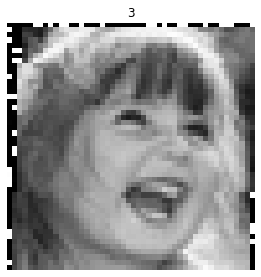

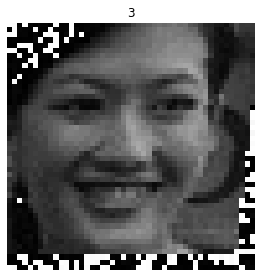

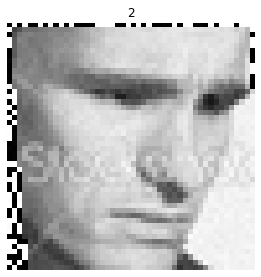

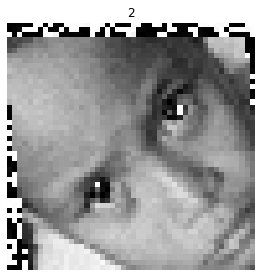

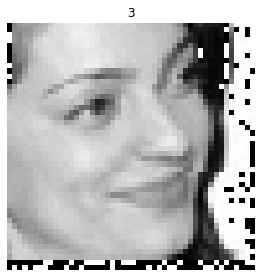

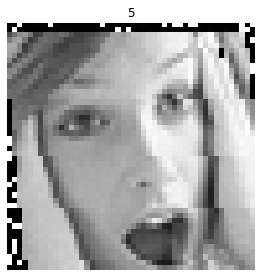

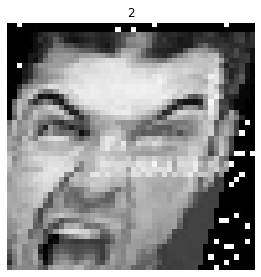

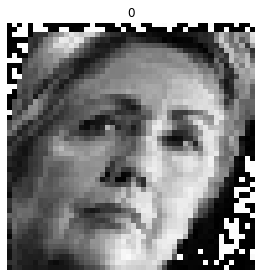

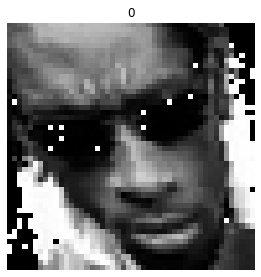

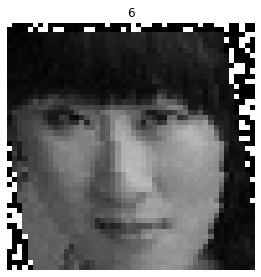

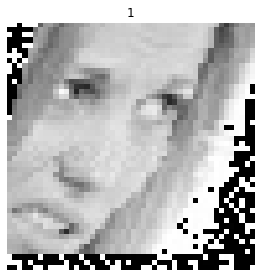

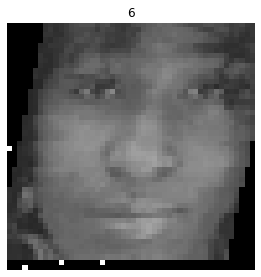

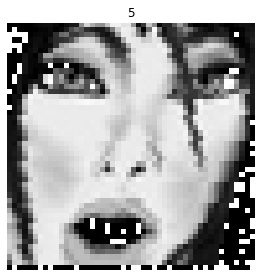

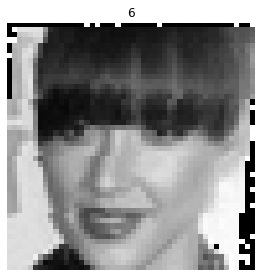

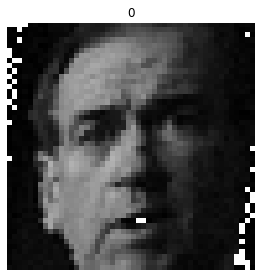

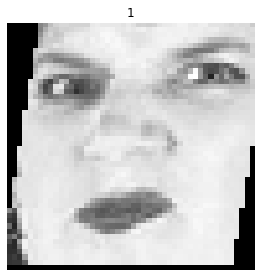

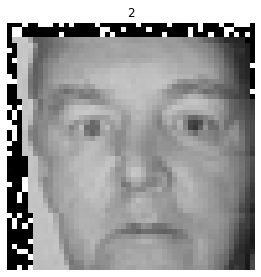

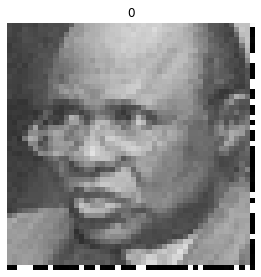

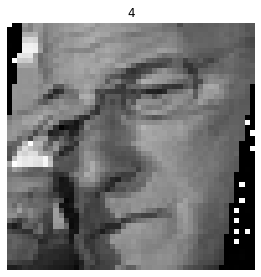

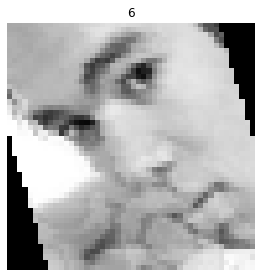

In [92]:
n_epoch = 100
best_epoch = 0

accuracy = []
highest_accuracy = 0

val_accuracy = []
highest_val_accuracy = 0

loss_ = []
lowest_loss_ = 100

val_loss = []
lowest_val_loss = 100


start = time.time()
for i in range(n_epoch):
    try:
        print(f"{i+1}/{n_epoch}")
        history = model.fit(train_ds, validation_data = val_ds, epochs = 1)
        
        train_ds = (
            orgDataset
            .unbatch()
            .shuffle(1000)
            .map(augment, num_parallel_calls=AUTOTUNE)
            .batch(batch_size)
            .prefetch(AUTOTUNE)
         )
        
        if highest_accuracy < history.history['accuracy'][0]:
            highest_accuracy = history.history['accuracy'][0]
            
        if highest_val_accuracy < history.history['val_accuracy'][0]:
            highest_val_accuracy = history.history['val_accuracy'][0]
            best_epoch = i+1
            
        if lowest_loss_ > history.history['loss'][0]:
            lowest_loss_ = history.history['loss'][0]
            
        if lowest_val_loss > history.history['val_loss'][0]:
            lowest_val_loss = history.history['val_loss'][0]       
            
            
        accuracy.append(history.history['accuracy'])
        val_accuracy.append(history.history['val_accuracy'])
        loss_.append(history.history['loss'])
        val_loss.append(history.history['val_loss'])
        
        if i%5 == 0:
            image_batch, label_batch = next(iter(train_ds))
            plt.figure(figsize=(10, 10))
            for i in range(1):
                ax = plt.subplot(2, 2, i + 1)
                plt.imshow(image_batch[i].numpy().astype("uint8"),cmap='gray')
                label = label_batch[i]
                plt.title(class_names[label])
                plt.axis("off")
    except ValueError:
        print(train_ds)
end = time.time()
duration = end - start
p1 = int(duration % 60)
p2 = int(duration / 60)
p3 = int(p2 % 60)
p2 = int(p2 / 60)
print(f"It took {p2}:{p3}:{p1}")
print(f"highest_accuracy: {highest_accuracy} highest_val_accuracy (Epoch: {best_epoch}) : {highest_val_accuracy} lowest_loss: {lowest_loss_} lowest_val_loss: {lowest_val_loss}")




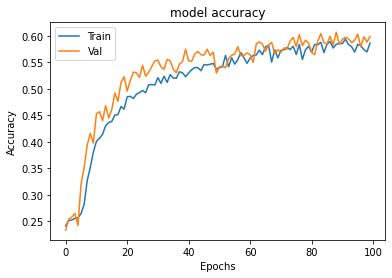

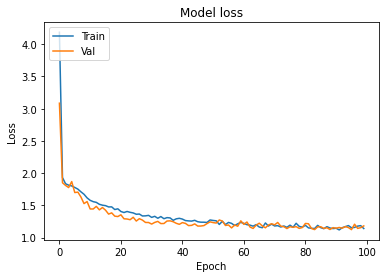

In [93]:
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig('graph1.png')
plt.show()

plt.plot(loss_)
plt.plot(val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig('graph2.png')
plt.show()


In [ ]:
import numpy as np
from keras.preprocessing import image
from PIL import Image, ImageOps 
test_image = image.load_img(r'C:\Users\tobia\Samlet CNN\data\test\4\33606.png', target_size = (48, 48))
test_image = ImageOps.grayscale(test_image) 
plt.imshow(test_image,cmap='gray')



In [ ]:
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = cnn.predict(test_image)
result = result.tolist()
result = result[0]

tal = [1,2,3,4,5,7,6]
mood = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']
plt.title('Mood')
plt.ylabel('accuracy')
plt.bar(mood, result)
plt.savefig('barGraph.png')
plt.show()


In [ ]:
print(history.history['accuracy'])

In [113]:
import itertools
from sklearn.metrics import confusion_matrix

In [122]:
y_pred = model.predict(train_ds)
y_pred = np.argmax(y_pred, axis=1)

cm_train = confusion_matrix(train_ds.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = {'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}
print(classification_report(train_ds.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

AttributeError: 'PrefetchDataset' object has no attribute 'classes'